In [1]:
from qcm_data import columns, extract_rotations, interpolate, integrate, read_hdf, read_csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.ndimage import uniform_filter, gaussian_filter

In [2]:
period = 10

theta = np.unwrap(read_hdf('data/Z-230901A.h5', 'data', columns['theta']))

s1_raw = read_hdf('data/Z-230901A.h5', 'data', columns['s1'])
theta_ext, s1_ext = extract_rotations(theta, s1_raw, limits=(np.deg2rad(270), np.deg2rad(390)))
s1_sgn = integrate(s1_ext, np.zeros(s1_ext.size), period)
s1_bgd = interpolate(s1_ext, period, period - 1)

freq_raw = -1.0 * read_hdf('data/Z-230901A.h5', 'data', 'Sensor1 [Fundamental freq]')
theta_ext, freq_ext = extract_rotations(theta, freq_raw, limits=(np.deg2rad(270), np.deg2rad(390)))
freq_sgn = integrate(freq_ext, np.zeros(freq_ext.size), period)
freq_bgd = interpolate(freq_ext, period, period - 2)
freq_int = integrate(freq_ext, freq_bgd, period)

In [3]:
old_s1_ftr = read_hdf('data/Z-230901A.h5', 'data', columns['s1_factor'])
old_s1_bgd = read_hdf('data/Z-230901A.h5', 'data', columns['s1_bgd'])
old_s1_sgn = read_hdf('data/Z-230901A.h5', 'data', columns['s1_sgn'])

# freq_bgd = interp1d(theta / (2 * np.pi), s1_bgd, 'linear', fill_value='extrapolate')(theta_ext[::period])
# freq_bgd = freq.max() / s1_signal.max() * np.nan_to_num(freq_bgd)
# freq_sgn = np.where(freq_bgd, (freq - freq_bgd), 0.0)

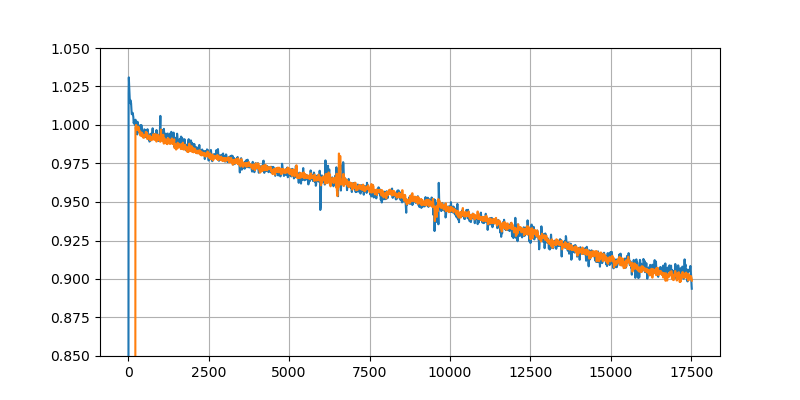

In [4]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
# ax.plot(theta_ext, freq_sgn / freq_sgn.max())
# ax.plot(theta_ext, freq_bgd / freq_bgd.max())
# ax.plot(theta_ext, (freq_sgn - freq_bgd) / (freq_sgn - freq_bgd).max())
ax.plot(theta_ext, freq_int / (0.97 * freq_int.max()))
# ax.plot(theta / (2 * np.pi), old_s1_sgn / old_s1_sgn.max())
# ax.plot(theta / (2 * np.pi), old_s1_bgd / old_s1_bgd.max())
ax.plot(theta / (2 * np.pi), (old_s1_sgn - old_s1_bgd) / (old_s1_sgn - old_s1_bgd).max())

ax.grid(True)
ax.set_ylim(0.85, 1.05)
plt.show()

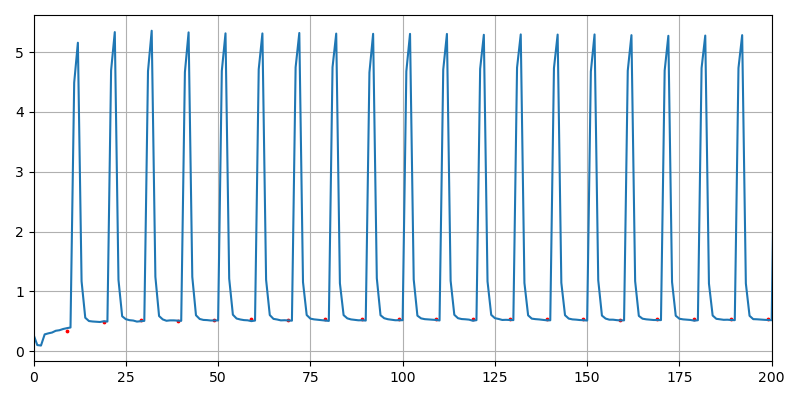

In [5]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(theta_ext, np.gradient(freq_ext))
ax.scatter(theta_ext[period - 1::period], np.gradient(freq_ext)[period - 4::period], s=3, c='r')
ax.grid(True)

ax.set_xlim(0, 200)
fig.tight_layout()
plt.show()

# Robust smoothing

In [6]:
from robust_holt_winters import robust_holt_winters
import jax
import jax.numpy as jnp
import optax as ox

# lambda1, lambda2, lambda_sigma = 0.027, 0.034, 0.004
# lambda1 *= 0.5

decays = np.array([[1.289e-2, 1.288e-2, 5.69e-1],
                   [1.289e-3, 1.288e-3, 5.69e-2]])

sgn = freq_int / freq_int.max()
x = theta_ext
size = x.size
N_start, N_warmup = int(0.01 * size), int(0.05 * size)

key = jax.random.PRNGKey(42)

series_list = []
for lambda1, lambda2, lambda_sigma in decays:
    smoother = robust_holt_winters(lambda1=lambda1, lambda2=lambda2, lambda_sigma=lambda_sigma)

    @jax.jit
    def step(state, new):
        elem, state = smoother.update(new, state)
        return state, jnp.array([elem, state.sigma])

    warmup, samples = jnp.array(sgn[N_start:N_warmup]), jnp.array(sgn[N_warmup:])

    state = smoother.init(warmup)

    series_list.append(jax.lax.scan(step, smoother.init(warmup), samples)[1])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


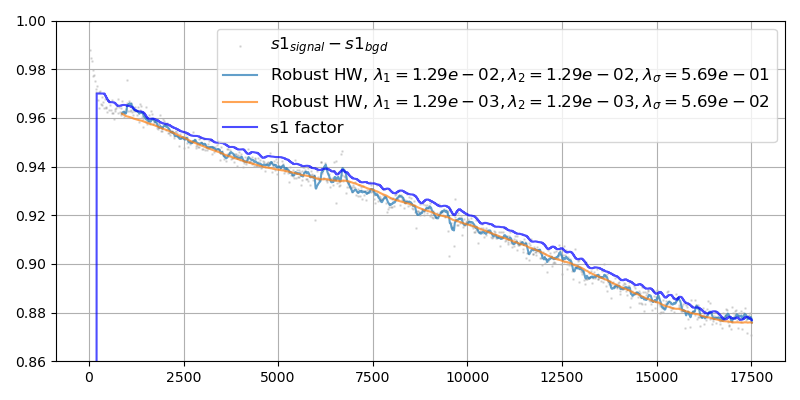

In [7]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(x[::20], sgn[::20], s=1, alpha=0.1, c='k', label=r'$s1_{signal} - s1_{bgd}$')

for (lambda1, lambda2, lambda_sigma), series in zip(decays, series_list):
        ax.plot(x[N_warmup:], series[:, 0], alpha=0.7,
                label=fr'Robust HW, $\lambda_1 = {lambda1:0.2e}, \lambda_2 = {lambda2:0.2e}, \lambda_{{\sigma}} = {lambda_sigma:0.2e}$')
        # ax.fill_between(x[N_warmup:], series[:, 0] - series[:, 1],
        #                 series[:, 0] + series[:, 1], color='r', alpha=0.5,
        #                 label=r"$\pm 3 \sigma$")

ax.plot(theta / (2 * np.pi), 0.97 * old_s1_ftr, c='b', alpha=0.7, label="s1 factor")

ax.legend(fontsize=12)
ax.set_ylim(0.86, 1.0)
ax.grid(True)
fig.tight_layout()
plt.show()

In [8]:
from robust_holt_winters import inject_hyperparams, meta_step

init_decay = 0.01
smoother = inject_hyperparams(robust_holt_winters)(lambda1=init_decay, lambda2=init_decay, lambda_sigma=init_decay)
opt = ox.inject_hyperparams(ox.adam)(learning_rate=ox.cosine_onecycle_schedule(2000, 3e-3))

In [9]:
from tqdm.auto import tqdm

series = jnp.array(sgn)
size = sgn.size
decay = jnp.full(3, -jnp.log(1 / init_decay - 1))
opt_state = opt.init(decay)

step = meta_step(smoother, opt)

N_warmup, N_train, N_test = int(0.02 * size), int(0.03 * size), int(0.02 * size)
key = jax.random.PRNGKey(42)
criteria, decays = [], []

for i in tqdm(range(2000)):
    idx = jax.random.randint(key, (1,), N_warmup, series.size - N_train - N_test)[0]
    state = smoother.init(series[idx - N_warmup:idx])
    train, test = series[idx:idx + N_train], series[idx + N_train:idx + N_train + N_test]
    crit, decay, state, opt_state = step(decay, train, test, state, opt_state)
    criteria.append(crit)
    decays.append(decay)

  0%|          | 0/2000 [00:00<?, ?it/s]

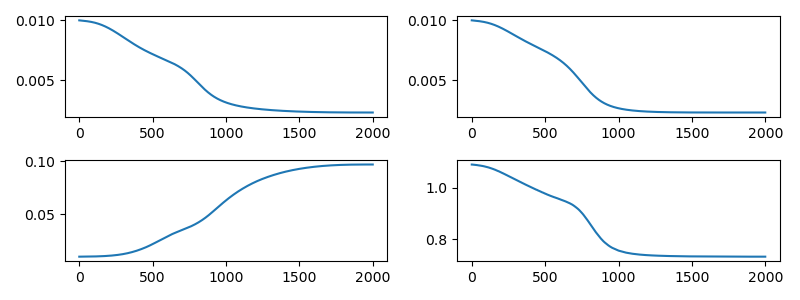

In [10]:
%matplotlib widget
fig, ax = plt.subplots(2, 2, figsize=(8, 3))
ax[0][0].plot(jax.nn.sigmoid(jnp.stack(decays)[:, 0]))
ax[0][1].plot(jax.nn.sigmoid(jnp.stack(decays)[:, 1]))
ax[1][0].plot(jax.nn.sigmoid(jnp.stack(decays)[:, 2]))
ax[1][1].plot(criteria)
fig.tight_layout()
plt.show()

In [11]:
jax.nn.sigmoid(decays[-1])

Array([0.00228908, 0.00228825, 0.09696817], dtype=float32)